# Introduction

This project is about building a neural network to classify and evaluate the CIFAR-10 dataset. The CIFAR dataset is an inbuilt dataset in torchvision library. It has about ten classes of images: `plane`, `car`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`. These images have 32 X 32 dimensions.

### Aim
1. To achieve an accuracy greater than 45%. 
2. To beat Detectocorp's benchmark accuracy of 70%

## Imports

In [1]:
## Import essential libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

In [2]:
# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomCrop(32),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                      ])
test_transforms = transforms.Compose([transforms.ToTensor()
                                    ])


# Create training set and define training dataloader

trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_10_data/', 
                                        download=True,
                                        train=True, transform=train_transforms
                                       )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True) 

# Create test set and define test dataloader

testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_10_data/', 
                                       download=True,
                                       train=False, 
                                       transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset

cat


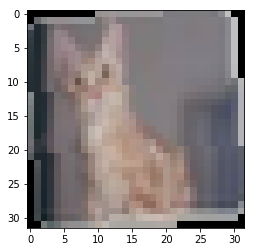

ship


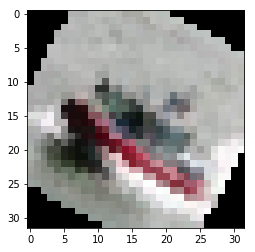

horse


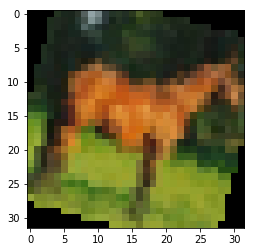

cat


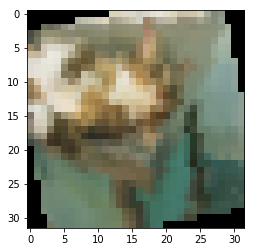

truck


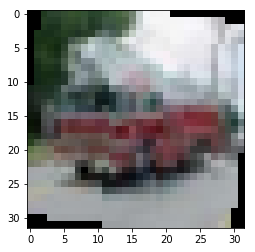

In [3]:
# Create a function for image plot
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
show5(trainloader)

cat


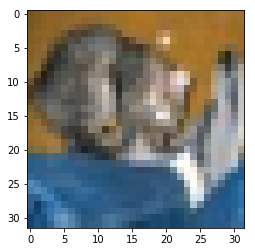

ship


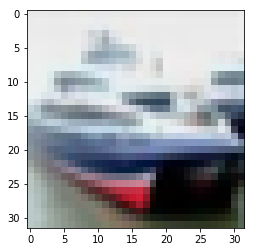

ship


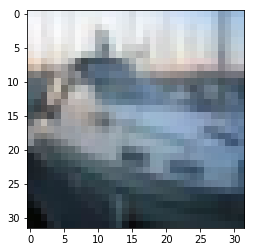

plane


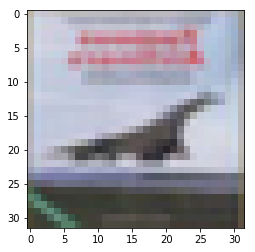

frog


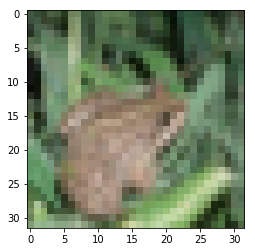

In [4]:
show5(testloader)

In [5]:
# Explore data
images, labels = next(iter(trainloader))
images.size()

torch.Size([64, 3, 32, 32])

This data contains 64 batches of pictures of 3 colours and 32 pixel

In [6]:
labels.size()

torch.Size([64])

In [7]:
images.ndimension()

4

In [8]:
labels.ndimension()

1

## Build your Neural Network


In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
#         Convolution layer
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 32,kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=3, stride=1, padding=1)
        
#         Fully connected layer
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 125)
        self.fc3 = nn.Linear(125, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p = 0.2)
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x
        
        
        

In [10]:
# Instantiate the model, loss function and optimizer
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [11]:
# Check model's params
model

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=125, bias=True)
  (fc3): Linear(in_features=125, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

## Running your Neural Network

In [12]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter tuning
epochs = 10
steps = 0
running_loss = 0
print_every = 250
model.to(device)
train_losses, test_losses = [],[]
for epoch in range(epochs):
    for index, (inputs, labels) in enumerate(trainloader):
        steps += 1
        # Move input and label tensors to the default device

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/print_every:.3f}.. ")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 1.994.. Test loss: 1.076.. 
Epoch 1/10.. Train loss: 1.661.. Test loss: 0.934.. 
Epoch 1/10.. Train loss: 1.525.. Test loss: 0.893.. 
Epoch 2/10.. Train loss: 1.461.. Test loss: 0.848.. 
Epoch 2/10.. Train loss: 1.399.. Test loss: 0.816.. 
Epoch 2/10.. Train loss: 1.363.. Test loss: 0.793.. 
Epoch 3/10.. Train loss: 1.307.. Test loss: 0.755.. 
Epoch 3/10.. Train loss: 1.299.. Test loss: 0.759.. 
Epoch 3/10.. Train loss: 1.277.. Test loss: 0.727.. 
Epoch 4/10.. Train loss: 1.231.. Test loss: 0.705.. 
Epoch 4/10.. Train loss: 1.212.. Test loss: 0.702.. 
Epoch 4/10.. Train loss: 1.206.. Test loss: 0.669.. 
Epoch 5/10.. Train loss: 1.181.. Test loss: 0.650.. 
Epoch 5/10.. Train loss: 1.166.. Test loss: 0.682.. 
Epoch 5/10.. Train loss: 1.166.. Test loss: 0.671.. 
Epoch 6/10.. Train loss: 1.133.. Test loss: 0.638.. 
Epoch 6/10.. Train loss: 1.121.. Test loss: 0.642.. 
Epoch 6/10.. Train loss: 1.110.. Test loss: 0.609.. 
Epoch 7/10.. Train loss: 1.094.. Test loss: 0.

The model is well trained as losses reduce with increase in epoch

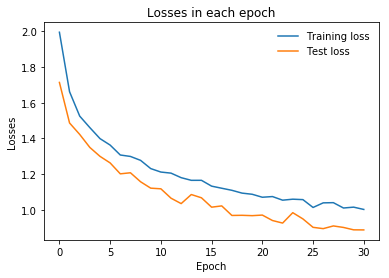

In [13]:
# Plot graph of losses
plt.plot(train_losses, label='Training loss');
plt.plot(test_losses, label='Test loss');
plt.legend(frameon=False);
plt.xlabel('Epoch');
plt.ylabel('Losses');
plt.title('Losses in each epoch');
plt.show();

## Testing your model

In [14]:
# Test accuracy of the model
accuracy = 0
model.eval()

with torch.no_grad():
                
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()
print(f'This model\'s accuracy is: {100*accuracy}%')

This model's accuracy is: 68.75%


## Save model


In [15]:
# Save model for later use
torch.save(model.state_dict(), 'checkpoint.pth')

## Recommendation


- My model is a novel one which has about 69% accuracy on the CIFAR-10 dataset. It comprises of convolutional and fully connected layers. Safe to be called a 'prototype' with lots of rooms for developments.

- Losses reduced with epoch, meaning with increased epoch, it will beat Detectocorp's model.

- I would recommend my company to use this model rather than acquiring another model